# Deep Learning

## Assignment 1

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import random
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere


def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for
    users with slow internet connections. Reports every 5% change in download
    progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()

    last_percent_reported = percent


def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename)
        filename, _ = urlretrieve(url + filename, dest_filename,
                                  reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception(
          'Failed to verify ' + dest_filename +
          '. Can you get to it with a browser?')
    return dest_filename


train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file. This should give you a set of directories, labeled A through J.

In [2]:
num_classes = 10
np.random.seed(133)


def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception(
            'Expected %d folders, one per class. Found %d instead.' % (
            num_classes, len(data_folders)))
    print(data_folders)
    return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


## Problem 1

Let's load the data in a more manageable format. Since, depending on the computer setup it might not be able to fit all data in memory. We'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.
We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.
A few images might not be readable, we'll just skip them.

In [3]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.


def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (ndimage.imread(image_file).astype(float) - 
                          pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                        (num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset
    
    
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
  
    return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping pickling.
./notMNIST_large/F.pickle already present - Skipping pickling.
./notMNIST_large/G.pickle already present - Skipping pickling.
./notMNIST_large/H.pickle already present - Skipping pickling.
./notMNIST_large/I.pickle already present - Skipping pickling.
./notMNIST_large/J.pickle already present - Skipping pickling.
./notMNIST_small/A.pickle already present - Skipping pickling.
./notMNIST_small/B.pickle already present - Skipping pickling.
./notMNIST_small/C.pickle already present - Skipping pickling.
./notMNIST_small/D.pickle already present - Skipping pickling.
./notMNIST_small/E.pickle already present - Skipping pickling.
./notMNIST_small/F.pickle already present - Skipping pi

## Problem 2
Let's display some of the pickled data to check it's still displaying properly.

In [4]:
pretty_labels = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J'}

def disp_sample_dataset(dataset, labels=[]):
    items = random.sample(range(len(dataset)), 8)
    for i, item in enumerate(items):
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        if len(labels):
            plt.title(pretty_labels[labels[item]])
        plt.imshow(dataset[item])
    
    
def disp_sample_pickled_dataset(dataset):
    for pickles in dataset:
        with open(pickles, "r") as f:
            image_set = pickle.load(f)
        items = random.sample(range(len(image_set)), 4)
        plt.figure()
        for i, item in enumerate(items):
            plt.subplot(1, 4, i+1)
            plt.axis('off')
            plt.imshow(image_set[item])

Samples from train dataset:


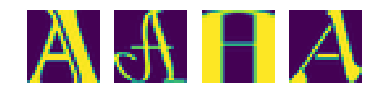

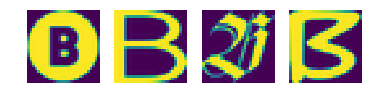

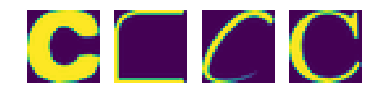

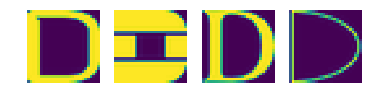

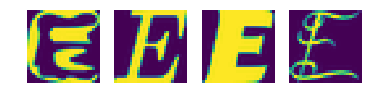

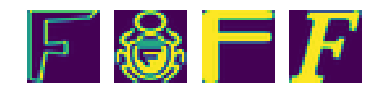

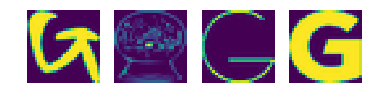

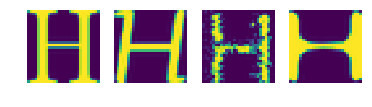

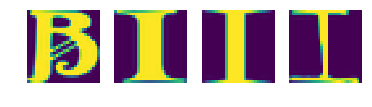

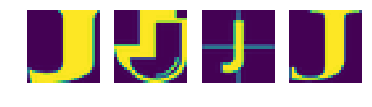

In [5]:
print('Samples from train dataset:')
disp_sample_pickled_dataset(train_datasets)

Samples from test dataset:


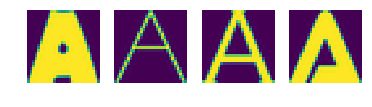

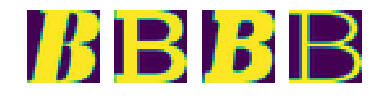

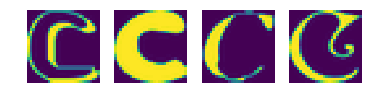

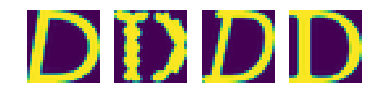

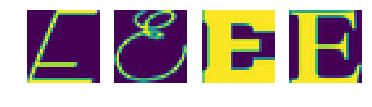

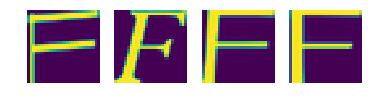

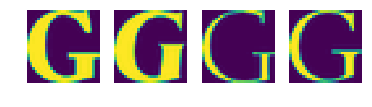

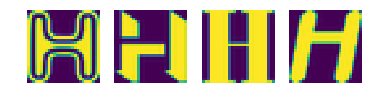

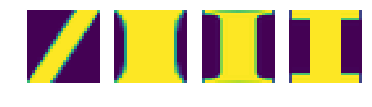

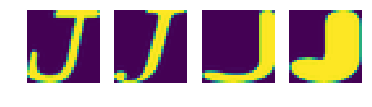

In [6]:
print('Samples from test dataset:')
disp_sample_pickled_dataset(test_datasets)

## Problem 3
Check that classes are balanced on the training and test datasets

In [7]:
def check_balance(dataset):
    for pickles in dataset:
        with open(pickles, "r") as data:
            image_set = pickle.load(data)
            print("Class %s: %i images" % (pickles, len(image_set)))
        

check_balance(train_datasets)
check_balance(test_datasets)

Class ./notMNIST_large/A.pickle: 52909 images
Class ./notMNIST_large/B.pickle: 52911 images
Class ./notMNIST_large/C.pickle: 52912 images
Class ./notMNIST_large/D.pickle: 52911 images
Class ./notMNIST_large/E.pickle: 52912 images
Class ./notMNIST_large/F.pickle: 52912 images
Class ./notMNIST_large/G.pickle: 52912 images
Class ./notMNIST_large/H.pickle: 52912 images
Class ./notMNIST_large/I.pickle: 52912 images
Class ./notMNIST_large/J.pickle: 52911 images
Class ./notMNIST_small/A.pickle: 1872 images
Class ./notMNIST_small/B.pickle: 1873 images
Class ./notMNIST_small/C.pickle: 1873 images
Class ./notMNIST_small/D.pickle: 1873 images
Class ./notMNIST_small/E.pickle: 1873 images
Class ./notMNIST_small/F.pickle: 1872 images
Class ./notMNIST_small/G.pickle: 1872 images
Class ./notMNIST_small/H.pickle: 1872 images
Class ./notMNIST_small/I.pickle: 1872 images
Class ./notMNIST_small/J.pickle: 1872 images


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed. The labels will be stored into a separate array of integers 0 through 9.
Also create a validation dataset for hyperparameter tuning.

In [8]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
    
    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class
    for label, pickle_file in enumerate(pickle_files):       
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class
                    
                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise
    
    return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Now, randomize the data for training and testing...

In [9]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels


train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

## Problem 4

Check that data is still good

Samples from train dataset:


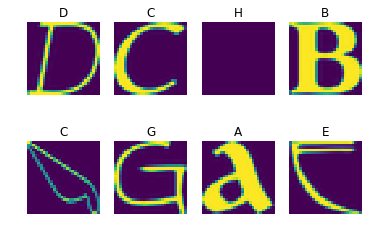

In [10]:
print('Samples from train dataset:')
disp_sample_dataset(train_dataset, train_labels)

Samples from test dataset:


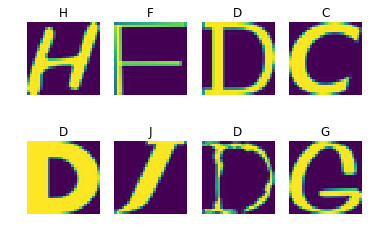

In [11]:
print('Samples from test dataset:')
disp_sample_dataset(test_dataset, test_labels)

Now let's save the data for later reuse

In [12]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
      print('Unable to save data to', pickle_file, ':', e)
      raise

In [13]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


## Problem 5
Measure how much overlap there is between training, validation and test samples.

In [14]:
def display_one_overlap(overlap, source_array, target_array):
    item = random.choice(overlap.keys())
    plt.figure()
    plt.title(item)
    plt.axis('off')
    plt.subplot(1, 2, 1)
    plt.imshow(source_array[item])
    plt.subplot(1, 2, 2)
    plt.imshow(target_array[overlap[item][0]])

In [15]:
def check_overlap(source_array, target_array):
    overlap = {}
    for index, img_s in enumerate(source_array):
        diff = target_array - img_s
        duplicates = np.where(np.sum(np.abs(diff), axis=(1, 2)) == 0)
        if len(duplicates[0]): # not empty
            overlap[index] = duplicates[0].tolist()
    return overlap, len(overlap)

In [16]:
%time overlap, n_overlap = check_overlap(test_dataset[:100, :, :], train_dataset)

CPU times: user 52.3 s, sys: 1min 8s, total: 2min
Wall time: 2min 10s


Number of overlaping samples found: 10. 
Corresponding indices:
{33: [157409], 69: [139511], 11: [118818, 183654], 77: [17647], 15: [156759], 17: [174599], 26: [38364], 91: [2402], 28: [116004], 30: [21214, 50715]}


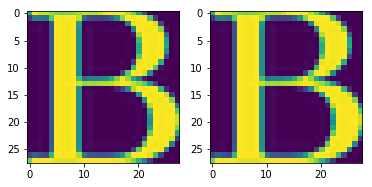

In [17]:
print("Number of overlaping samples found: %i. \nCorresponding indices:" % n_overlap)
print(overlap)

display_one_overlap(overlap, test_dataset, train_dataset)

In [18]:
def check_near_overlap(source_array, target_array, MAX_ABS_DIFF=10):
    overlap = {}
    for index, img_s in enumerate(source_array):
        diff = target_array - img_s
        duplicates = np.where(np.sum(np.abs(diff), axis=(1, 2)) < MAX_ABS_DIFF)
        if len(duplicates[0]): # not empty
            overlap[index] = duplicates[0].tolist()
    return overlap, len(overlap)

And now let's do a sanity check...

In [19]:
%time near_overlap, n_near_overlap = check_near_overlap(test_dataset[:100, :, :], train_dataset)

CPU times: user 47.7 s, sys: 1min 1s, total: 1min 49s
Wall time: 1min 56s


Number of near overlaping samples found: 28. 
Corresponding indices:
{11: [118818, 183654], 15: [156759], 16: [4822], 17: [174599], 18: [71625, 159200], 26: [19558, 38364], 28: [116004], 30: [21214, 50715], 32: [27259, 129654, 196838], 33: [67941, 157409, 157875], 39: [175291], 45: [21712], 47: [150646], 48: [75638], 49: [5590], 51: [63848], 54: [165680, 176330], 59: [170, 43192, 47802, 53506, 89609, 112277, 115801, 155739, 163674, 176070, 189683, 191124, 192361, 195150, 198851], 67: [38717], 68: [79947], 69: [139511], 71: [179102], 76: [49529], 77: [17647], 87: [22334], 88: [48010], 91: [2402], 99: [24322]}


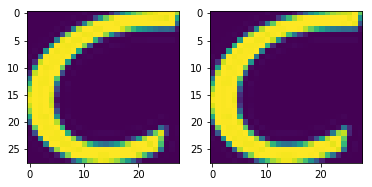

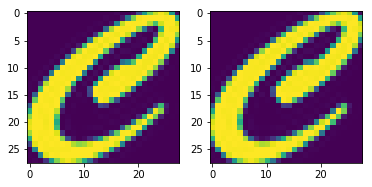

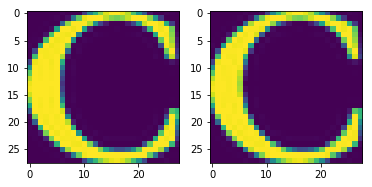

In [20]:
print("Number of near overlaping samples found: %i. \nCorresponding indices:" % n_near_overlap)
print(near_overlap)

display_one_overlap(near_overlap, test_dataset, train_dataset)
display_one_overlap(near_overlap, test_dataset, train_dataset)
display_one_overlap(near_overlap, test_dataset, train_dataset)

The previous routines work well, but are very inefficient. We have to figure a way of improving scalability to apply it to the whole dataset...

One technique is to reduce the intermediate cross-check between a single labeled class, as the overlaps will sure have the same labels.

In [21]:
def sanitize_data(source_data, source_labels, target_data, target_labels):
    sanitized_data = np.empty((0, image_size, image_size))
    sanitized_labels = []
    for label in np.unique(target_labels):
        # Create a vector of booleans with True where labels are equal to current label
        idx_source = source_labels == label
        idx_target = target_labels == label
        
        # Filter source and target data to only values matching current label
        filtered_source_data = source_data[idx_source]
        filtered_target_data = target_data[idx_target]
        filtered_target_labels = target_labels[idx_target]
        overlap, _ = check_near_overlap(filtered_source_data, filtered_target_data)
        if overlap: #not empty
            unique_data = np.delete(filtered_target_data, np.concatenate(overlap.values()), axis=0)
            unique_labels = np.delete(filtered_target_labels, np.concatenate(overlap.values()), axis=0)
            sanitized_data = np.insert(sanitized_data, 0, unique_data, axis=0)
            sanitized_labels = np.insert(sanitized_labels, 0, unique_labels, axis=0)
        
    return randomize(sanitized_data, sanitized_labels)

Let's do a quick sanity check, run sanitize with same sets should return empty arrays...

In [22]:
%time print(sanitize_data(valid_dataset[:100, :, :], valid_labels[:100], valid_dataset[:100, :, :], valid_labels[:100]))

(array([], shape=(0, 28, 28), dtype=float64), array([], dtype=float64))
CPU times: user 8.85 ms, sys: 2.25 ms, total: 11.1 ms
Wall time: 10.7 ms


Will this run on the whole dataset? Let's try this on the test dataset first...

In [23]:
%time clean_test_dataset, clean_test_labels = sanitize_data(valid_dataset, valid_labels, test_dataset, test_labels)

print('Test dataset without duplicates from valid dataset: %i' % len(clean_test_dataset))

CPU times: user 20.4 s, sys: 8.8 s, total: 29.2 s
Wall time: 29.7 s
Test dataset without duplicates from valid dataset: 9596


In [24]:
%time clean_test_dataset, clean_test_labels = sanitize_data(train_dataset, train_labels, test_dataset, test_labels)

print('Test dataset without duplicates from train dataset: %i' % len(clean_test_dataset))

CPU times: user 6min 2s, sys: 7.53 s, total: 6min 9s
Wall time: 6min 23s
Test dataset without duplicates from train dataset: 7416


In [25]:
%time clean_valid_dataset, clean_valid_labels = sanitize_data(test_dataset, test_labels, valid_dataset, valid_labels)

print('Valid dataset without duplicates from test dataset: %i' % len(clean_valid_dataset))

CPU times: user 16.2 s, sys: 410 ms, total: 16.6 s
Wall time: 16.8 s
Valid dataset without duplicates from test dataset: 9650


In [26]:
%time clean_valid_dataset, clean_valid_labels = sanitize_data(train_dataset, train_labels, valid_dataset, valid_labels)

print('Valid dataset without duplicates from train dataset: %i' % len(clean_valid_dataset))

CPU times: user 6min 25s, sys: 10.1 s, total: 6min 35s
Wall time: 6min 52s
Valid dataset without duplicates from train dataset: 7862


## Problem 6

Let's check how an off-the-shelf classifier will fare using 50, 100, 1000 and 5000 training samples. For this we will use the LogisticRegression model from sklearn.

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X_train = train_dataset.reshape(train_dataset.shape[0], -1)
X_test = clean_test_dataset.reshape(clean_test_dataset.shape[0], -1)
X_valid = clean_valid_dataset.reshape(clean_valid_dataset.shape[0], -1)
classes = pretty_labels.values()

Predicting chars on the testing set:
             precision    recall  f1-score   support

          A       0.74      0.55      0.63       747
          B       0.43      0.53      0.48       831
          C       0.62      0.09      0.15       760
          D       0.64      0.03      0.05       766
          E       0.37      0.62      0.46       801
          F       0.64      0.70      0.67       777
          G       0.35      0.76      0.48       801
          H       0.41      0.26      0.32       702
          I       0.44      0.65      0.52       500
          J       0.78      0.64      0.70       731

avg / total       0.54      0.48      0.44      7416



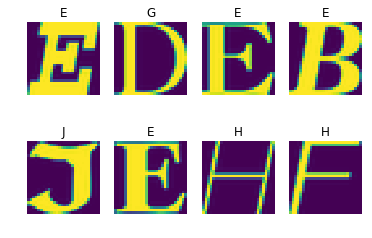

In [28]:
N_SAMPLES = 50
clf = LogisticRegression()
clf.fit(X_train[:N_SAMPLES, :], train_labels[:N_SAMPLES])

print("Predicting chars on the testing set:")
y_pred = clf.predict(X_test)
print(classification_report(clean_test_labels, y_pred,target_names=classes))
# print(confusion_matrix(clean_test_labels, y_pred))
disp_sample_dataset(X_test.reshape((X_test.shape[0], image_size, image_size)), y_pred)

Predicting chars on the testing set:
             precision    recall  f1-score   support

          A       0.89      0.75      0.81       747
          B       0.65      0.55      0.60       831
          C       0.73      0.76      0.75       760
          D       0.91      0.65      0.76       766
          E       0.45      0.74      0.56       801
          F       0.60      0.69      0.64       777
          G       0.69      0.68      0.68       801
          H       0.56      0.36      0.44       702
          I       0.62      0.59      0.60       500
          J       0.73      0.79      0.76       731

avg / total       0.68      0.66      0.66      7416



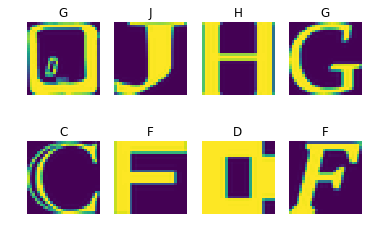

In [29]:
N_SAMPLES = 100
clf = LogisticRegression()
clf.fit(X_train[:N_SAMPLES, :], train_labels[:N_SAMPLES])

print("Predicting chars on the testing set:")
y_pred = clf.predict(X_test)
print(classification_report(clean_test_labels, y_pred,target_names=classes))
# print(confusion_matrix(clean_test_labels, y_pred))
disp_sample_dataset(X_test.reshape((X_test.shape[0], image_size, image_size)), y_pred)

Predicting chars on the testing set:
             precision    recall  f1-score   support

          A       0.84      0.82      0.83       747
          B       0.81      0.80      0.80       831
          C       0.79      0.84      0.81       760
          D       0.84      0.83      0.83       766
          E       0.79      0.76      0.78       801
          F       0.81      0.84      0.83       777
          G       0.80      0.81      0.80       801
          H       0.84      0.76      0.80       702
          I       0.64      0.68      0.66       500
          J       0.79      0.80      0.80       731

avg / total       0.80      0.80      0.80      7416



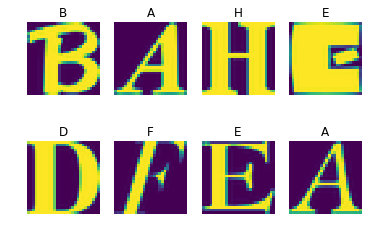

In [30]:
N_SAMPLES = 1000
clf = LogisticRegression()
clf.fit(X_train[:N_SAMPLES, :], train_labels[:N_SAMPLES])

print("Predicting chars on the testing set:")
y_pred = clf.predict(X_test)
print(classification_report(clean_test_labels, y_pred,target_names=classes))
# print(confusion_matrix(clean_test_labels, y_pred))
disp_sample_dataset(X_test.reshape((X_test.shape[0], image_size, image_size)), y_pred)

Predicting chars on the testing set:
             precision    recall  f1-score   support

          A       0.83      0.81      0.82       747
          B       0.85      0.82      0.84       831
          C       0.84      0.85      0.85       760
          D       0.87      0.85      0.86       766
          E       0.83      0.78      0.80       801
          F       0.83      0.87      0.85       777
          G       0.84      0.85      0.84       801
          H       0.83      0.79      0.81       702
          I       0.62      0.71      0.66       500
          J       0.79      0.83      0.81       731

avg / total       0.82      0.82      0.82      7416



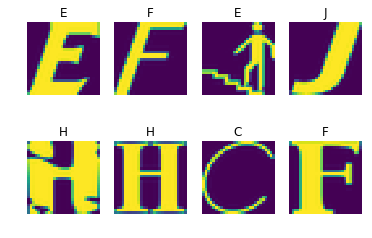

In [31]:
N_SAMPLES = 5000
clf = LogisticRegression()
clf.fit(X_train[:N_SAMPLES, :], train_labels[:N_SAMPLES])

print("Predicting chars on the testing set:")
y_pred = clf.predict(X_test)
print(classification_report(clean_test_labels, y_pred,target_names=classes))
# print(confusion_matrix(clean_test_labels, y_pred))
disp_sample_dataset(X_test.reshape((X_test.shape[0], image_size, image_size)), y_pred)